# Results - Regression on Real-world Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_results.ipynb)

## Prerequisites

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2
%matplotlib inline

from rich import print

random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_metrics_bar,
    get_metrics_summary,
    plot_cv_indices,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_synth_regression_scoring, SHM_Scoring

from bench_utils import extract_metrics

## Data Loading

In [4]:
# base = "s20_mixed_regression_AB_dssize.pkl"
# base = Path(RESULT_PATH, base)

# base = pd.read_pickle(base)

In [5]:
res = "s10_synthetic_regression_AB_undersampling.pkl"
res = Path(RESULT_PATH, res)

res = pd.read_pickle(res)

### Combine results from baseline and our models

In [6]:
# results = pd.concat(
#     [
#         base[(base["model"] == "BASE") | (base["model"] == "ClusterCentroids_2")],
#         res[(res["model"] != "BASE") & (res["model"] != "ClusterCentroids")],
#     ],
#     ignore_index=True,
# )

# results = results.replace("ClusterCentroids_2", "ClusterCentroids")

results = res

In [7]:
# source columns
shm_scoring = SHM_Scoring()

mse_individual = ["test_mse_0.0"] + shm_scoring.SYNTH_MSE_RESULTS
mse_individual


[
    'test_mse_0.0',
    'test_mse_2.2',
    'test_mse_2.5',
    'test_mse_2.8',
    'test_mse_3.1',
    'test_mse_3.4',
    'test_mse_3.8',
    'test_mse_4.1',
    'test_mse_4.4',
    'test_mse_4.7',
    'test_mse_5.0',
    'test_mse_6.7',
    'test_mse_8.3',
    'test_mse_10.0',
    'test_mse_12.0',
    'test_mse_14.0',
    'test_mse_16.0',
    'test_mse_18.0',
    'test_mse_20.0',
    'test_mse_22.0',
    'test_mse_24.0',
    'test_mse_26.0',
    'test_mse_28.0',
    'test_mse_30.0',
    'test_mse_32.0',
    'test_mse_34.0',
    'test_mse_36.0',
    'test_mse_38.0',
    'test_mse_40.0'
]

In [8]:
# target columns
mse_contr_individual = [
    item.replace("test_mse_", "mse_contr_") for item in mse_individual
]
mse_contr_individual


[
    'mse_contr_0.0',
    'mse_contr_2.2',
    'mse_contr_2.5',
    'mse_contr_2.8',
    'mse_contr_3.1',
    'mse_contr_3.4',
    'mse_contr_3.8',
    'mse_contr_4.1',
    'mse_contr_4.4',
    'mse_contr_4.7',
    'mse_contr_5.0',
    'mse_contr_6.7',
    'mse_contr_8.3',
    'mse_contr_10.0',
    'mse_contr_12.0',
    'mse_contr_14.0',
    'mse_contr_16.0',
    'mse_contr_18.0',
    'mse_contr_20.0',
    'mse_contr_22.0',
    'mse_contr_24.0',
    'mse_contr_26.0',
    'mse_contr_28.0',
    'mse_contr_30.0',
    'mse_contr_32.0',
    'mse_contr_34.0',
    'mse_contr_36.0',
    'mse_contr_38.0',
    'mse_contr_40.0'
]

In [9]:
full_mse = results[mse_individual].sum(axis=1) / len(mse_individual)

for col in results[mse_individual]:
    tmp = results[col] * 100 / len(mse_individual) / full_mse
    results[col.replace("test_mse_", "mse_contr_")] = tmp

# sanity check, all contributions have to sum up to 100% every time for each defect
assert results[mse_contr_individual].sum(axis=1).sum() / len(results) == 100

## Plot MSE

/tmp/ipykernel_4046345/4108673906.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


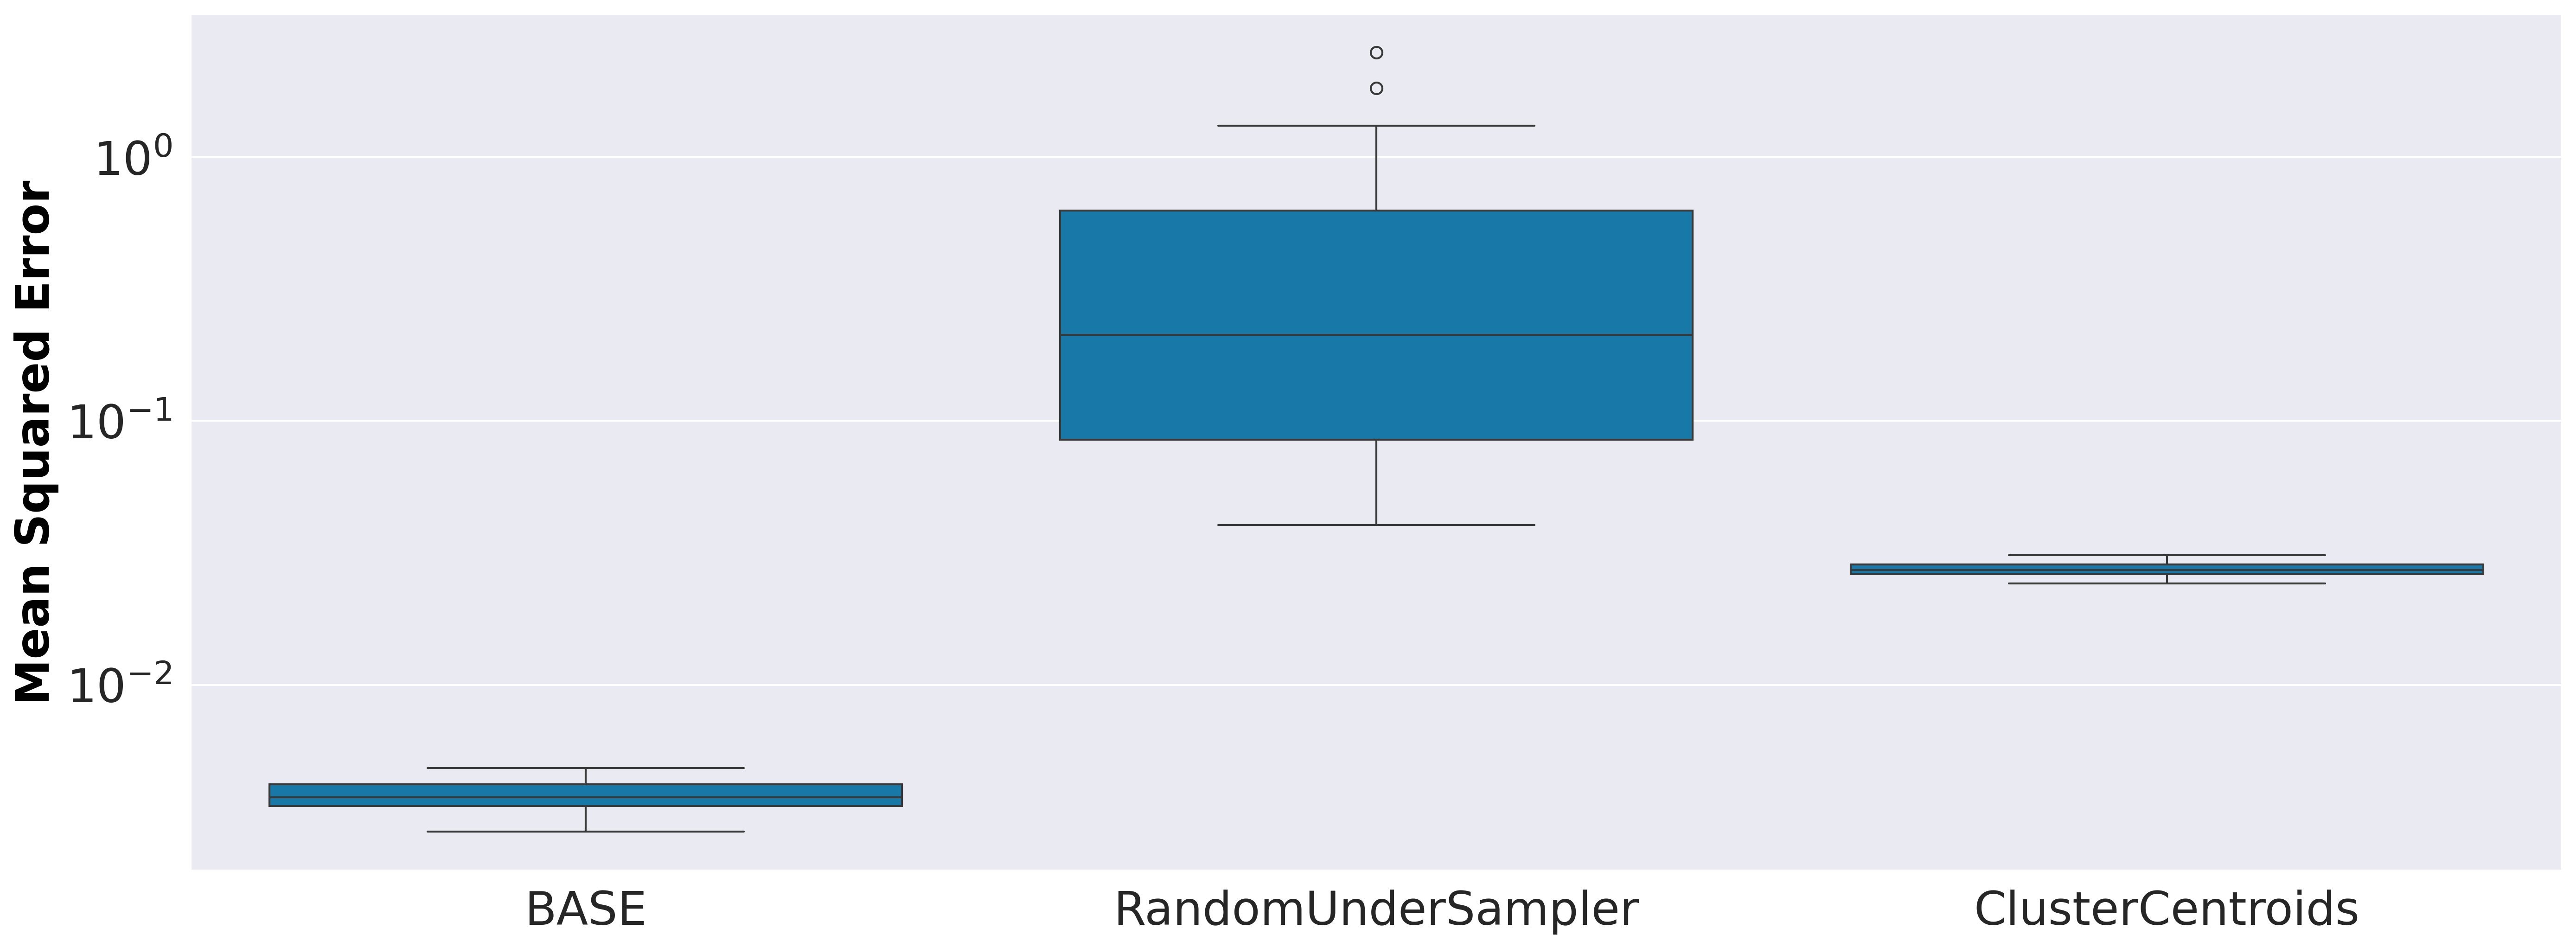

In [10]:
axis_font = {  #'family': 'Times',
    "color": "black",
    "weight": "bold",
    "size": 24,
}

fig = plot_metrics(
    extract_metrics(results, ["test_mse_2.8_40.0"]),
    palette="winter",
    # errwidth=3.5,
    # capsize=0.4,
)

plt.yscale("log")
# plt.ylim((0, 1.3))
plt.ylabel("Mean Squared Error", fontdict=axis_font)
plt.xlabel("")
fig.get_legend().remove()

labels = [item.get_text() for item in plt.gca().get_xticklabels()]

plt.gca().set_xticklabels(labels)

fname = Path(RESULT_PATH, r"s10_undersampling_strategies.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

In [11]:
extract_metrics(results, ["test_mse_2.8_40.0"]).groupby(["model", "metrics"]).mean()

,,values
model,metrics,
BASE,test_mse_2.8_40.0,0.003825
ClusterCentroids,test_mse_2.8_40.0,0.027354
RandomUnderSampler,test_mse_2.8_40.0,0.437638


## Plot MSE wrt Defect Size

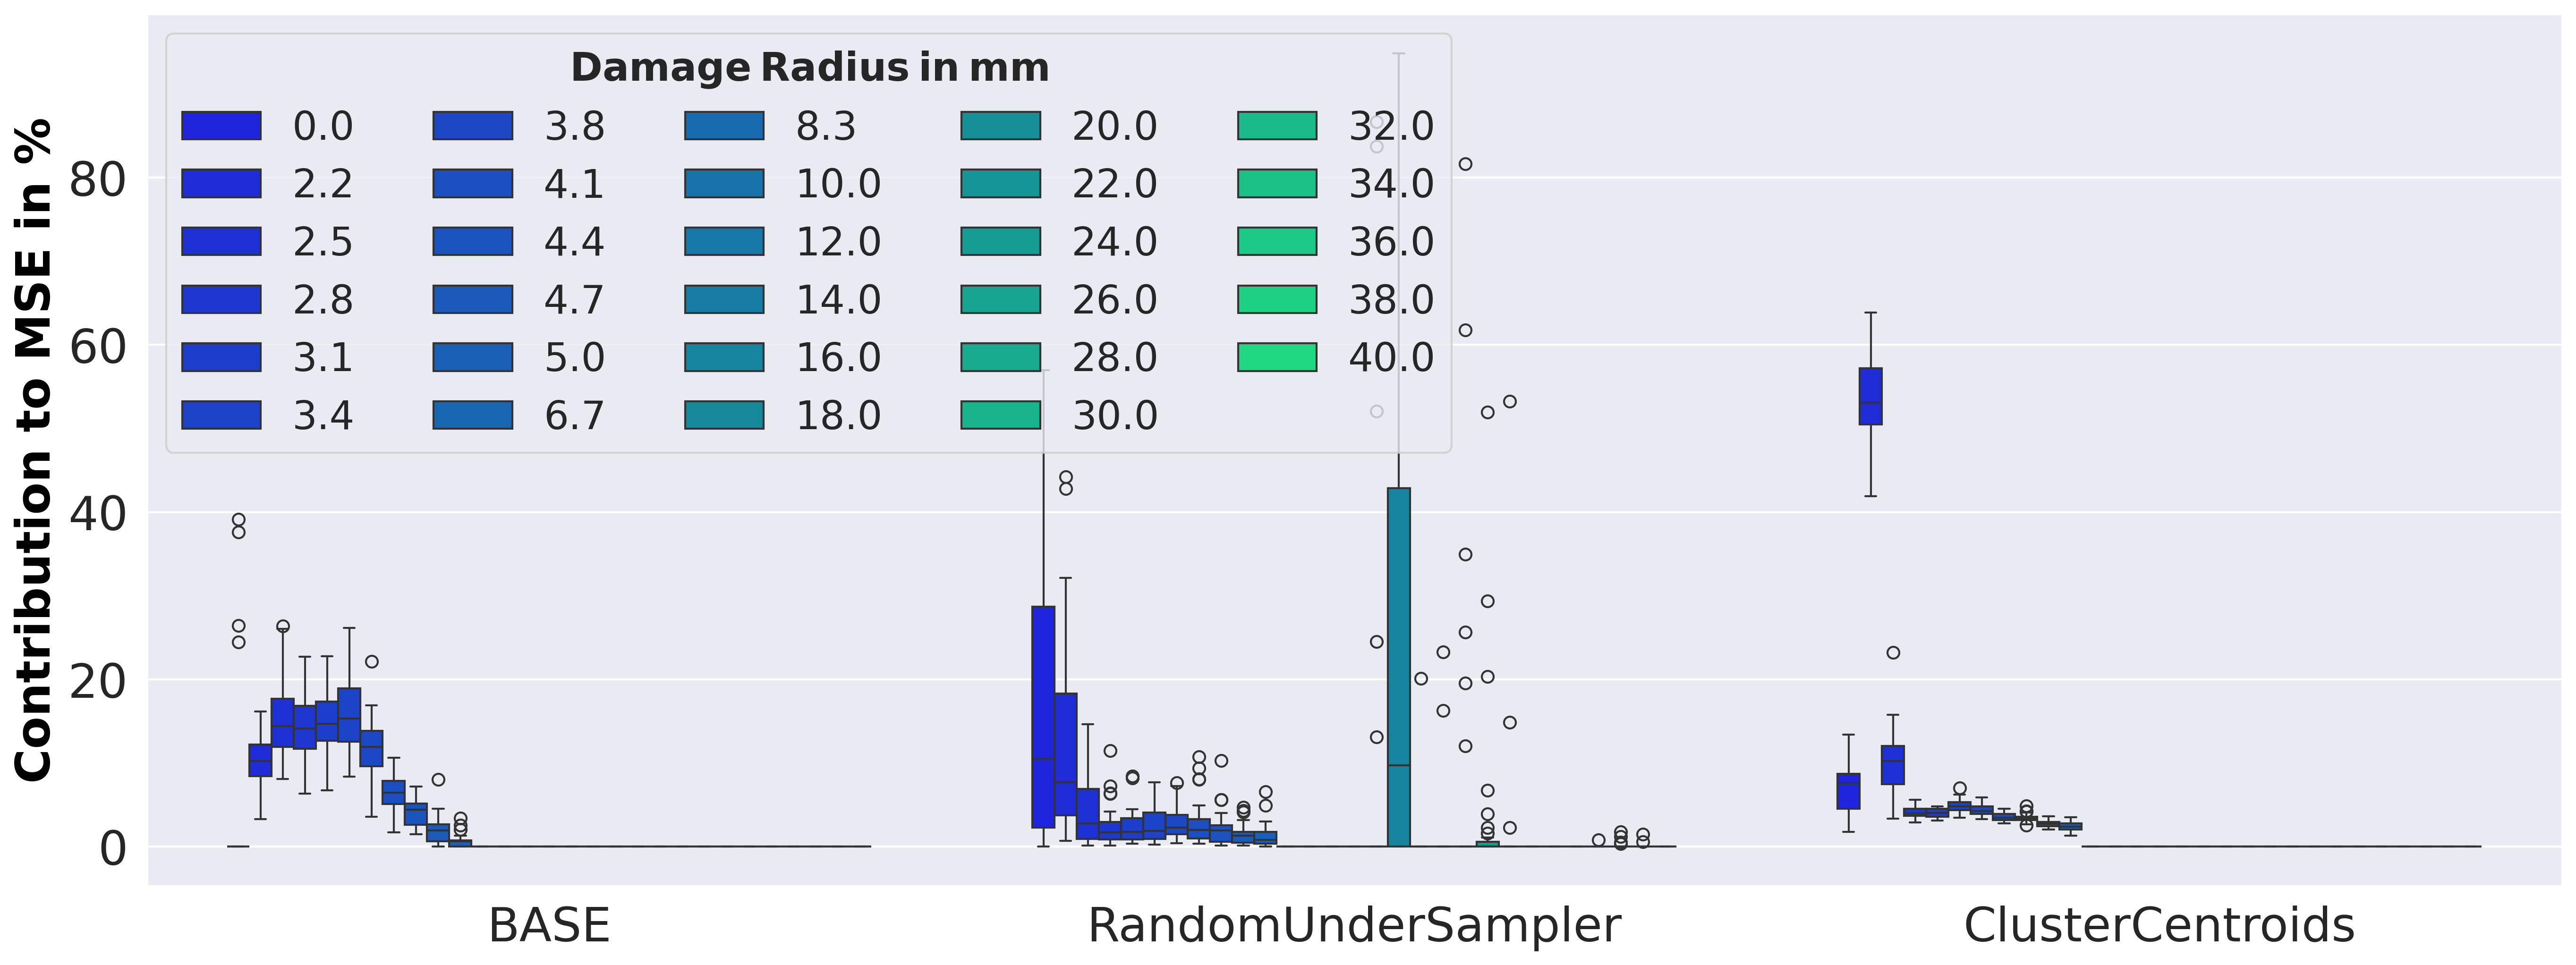

In [12]:
fig = plot_metrics(
    extract_metrics(results, mse_contr_individual),
    palette="winter",
    # errwidth=2.5,
    # capsize=0.03,
)

# plt.ylim((-1, 60))
plt.ylabel("Contribution to MSE in %", fontdict=axis_font)
plt.xlabel("")

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace("mse_contr_", "") for item in labels]
plt.legend(
    handles,
    new_labels,
    ncol=5,
    loc="best",
    title="$\\bf{Damage \:Radius} \:in\:mm$",
    title_fontsize=20,
    fontsize=20,
)

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
# plt.gca().set_xticklabels(labels)


fname = Path(RESULT_PATH, r"s10_undersampling_mse_individual_contribution.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

In [13]:
df = extract_metrics(results, ["test_mse_0.0_40.0"])
print(get_metrics_summary(df))

mean       std
model              metrics                              
BASE               test_mse_0.0_40.0  0.004972  0.001226
ClusterCentroids   test_mse_0.0_40.0  0.083478  0.008411
RandomUnderSampler test_mse_0.0_40.0  0.475676  0.491505

## Plot Train/Inference times

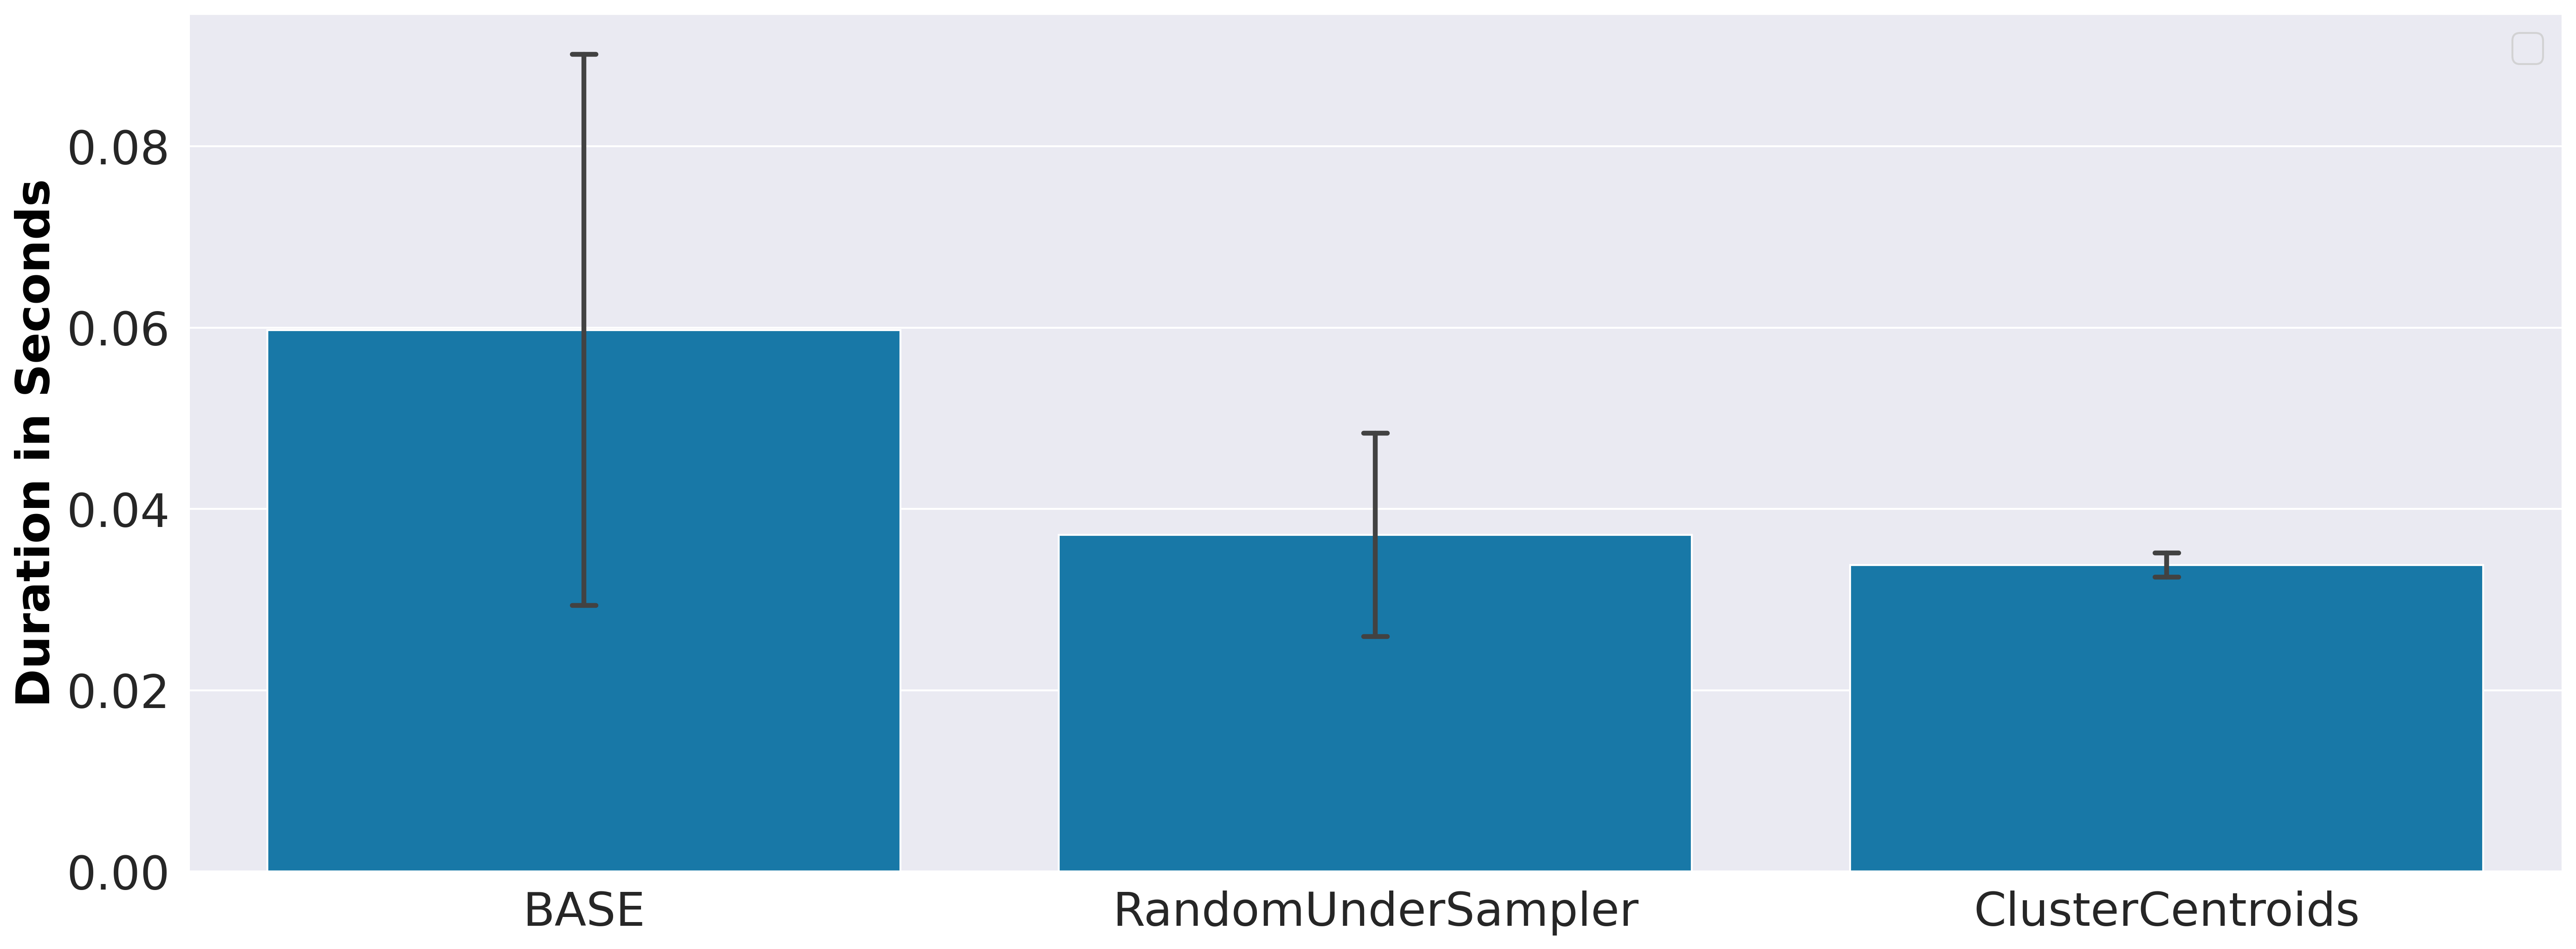

In [14]:
fig = plot_metrics_bar(
    extract_metrics(results, ["score_time"]),
    palette="winter",
    errwidth=2.5,
    capsize=0.03,
)

# plt.ylim((-1, 60))
plt.ylabel("Duration in Seconds", fontdict=axis_font)
plt.xlabel("")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    [],
    ncol=5,
    loc="best",
    title="",
    title_fontsize=20,
    fontsize=20,
)

fname = Path(RESULT_PATH, r"s10_undersampling_strategies_time.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

In [15]:
df = extract_metrics(results, ["fit_time", "score_time"])
print(get_metrics_summary(df))

mean       std
model              metrics                       
BASE               fit_time    0.014363  0.016936
                   score_time  0.059733  0.030391
ClusterCentroids   fit_time      0.0793  0.005859
                   score_time   0.03381  0.001339
RandomUnderSampler fit_time    0.017969  0.005190
                   score_time  0.037136  0.011216